In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Reshape
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

########################
# 1. Load & Preprocess #
########################
df = pd.read_csv('/content/pamap2_HAR_raw.csv')
df = df.head(25000)

# Linear Interpolation and drop NANs
sensor_columns = [col for col in df.columns if col not in ['timestamp', 'activityID', 'activity_name']]
sensor_data = df[sensor_columns]
sensor_data = sensor_data.interpolate(method='linear', axis=0)
sensor_data = sensor_data.dropna()

# Feature Engineering
sensor_data['hand_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_hand_3D_acceleration_1']**2 +
    sensor_data['IMU_hand_3D_acceleration_2']**2 +
    sensor_data['IMU_hand_3D_acceleration_3']**2
)
sensor_data['chest_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_acceleration_1']**2 +
    sensor_data['IMU_chest_3D_acceleration_2']**2 +
    sensor_data['IMU_chest_3D_acceleration_3']**2
)
sensor_data['chest_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_gyroscope_1']**2 +
    sensor_data['IMU_chest_3D_gyroscope_2']**2 +
    sensor_data['IMU_chest_3D_gyroscope_3']**2
)
sensor_data['chest_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_magnetometer_1']**2 +
    sensor_data['IMU_chest_3D_magnetometer_2']**2 +
    sensor_data['IMU_chest_3D_magnetometer_3']**2
)
sensor_data['ankle_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_acceleration_1']**2 +
    sensor_data['IMU_ankle_3D_acceleration_2']**2 +
    sensor_data['IMU_ankle_3D_acceleration_3']**2
)
sensor_data['ankle_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_gyroscope_1']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_2']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_3']**2
)
sensor_data['ankle_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_magnetometer_1']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_2']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_3']**2
)

# Drop original columns
cols_to_drop = [
    'IMU_chest_3D_acceleration_1', 'IMU_chest_3D_acceleration_2', 'IMU_chest_3D_acceleration_3',
    'IMU_hand_3D_acceleration_1', 'IMU_hand_3D_acceleration_2', 'IMU_hand_3D_acceleration_3',
    'IMU_chest_3D_gyroscope_1', 'IMU_chest_3D_gyroscope_2', 'IMU_chest_3D_gyroscope_3',
    'IMU_hand_3D_gyroscope_1', 'IMU_hand_3D_gyroscope_2', 'IMU_hand_3D_gyroscope_3',
    'IMU_chest_3D_magnetometer_1', 'IMU_chest_3D_magnetometer_2', 'IMU_chest_3D_magnetometer_3',
    'IMU_ankle_3D_acceleration_1', 'IMU_ankle_3D_acceleration_2', 'IMU_ankle_3D_acceleration_3',
    'IMU_ankle_3D_gyroscope_1', 'IMU_ankle_3D_gyroscope_2', 'IMU_ankle_3D_gyroscope_3',
    'IMU_ankle_3D_magnetometer_1', 'IMU_ankle_3D_magnetometer_2', 'IMU_ankle_3D_magnetometer_3'
]
sensor_data = sensor_data.drop(cols_to_drop, axis=1)

# Scale data
scaler = MinMaxScaler()
sensor_data_scaled = scaler.fit_transform(sensor_data)
sensor_data_scaled = pd.DataFrame(sensor_data_scaled, columns=sensor_data.columns)

# Reintroduce for splitting
sensor_data_scaled['timestamp'] = df['timestamp']
train_threshold = df['timestamp'].quantile(0.8)
train_data = sensor_data_scaled[sensor_data_scaled['timestamp'] < train_threshold].drop(columns=['timestamp'])
test_data = sensor_data_scaled[sensor_data_scaled['timestamp'] >= train_threshold].drop(columns=['timestamp'])

In [2]:
#######################################
# 2. Create LSTM Sequences for Inputs #
#######################################
def create_sequences(data, seq_length=20):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data.iloc[i : i + seq_length].values)
    return np.array(sequences)

X_train = create_sequences(train_data)
X_test = create_sequences(test_data)

######################################
# 3. Define & Train LSTM Autoencoder #
######################################
class LSTMAutoencoder(Model):
    def __init__(self, input_shape):
        super(LSTMAutoencoder, self).__init__()
        self.encoder_lstm1 = LSTM(128, activation='relu', return_sequences=True)
        self.encoder_lstm2 = LSTM(64, activation='relu', return_sequences=False)
        self.decoder_repeat = RepeatVector(input_shape[0])
        self.decoder_lstm1 = LSTM(64, activation='relu', return_sequences=True)
        self.decoder_lstm2 = LSTM(128, activation='relu', return_sequences=True)
        self.decoder_dense = Dense(input_shape[1], activation='linear')
        self.reshape_layer = Reshape(input_shape)

    def call(self, inputs):
        x = self.encoder_lstm1(inputs)
        x = self.encoder_lstm2(x)
        x = self.decoder_repeat(x)
        x = self.decoder_lstm1(x)
        x = self.decoder_lstm2(x)
        x = self.decoder_dense(x)
        return self.reshape_layer(x)

seq_length = X_train.shape[1]
num_features = X_train.shape[2]
autoencoder = LSTMAutoencoder((seq_length, num_features))
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, verbose=1)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 87ms/step - loss: 0.0190
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - loss: 2.9344e-04
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - loss: 1.9372e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - loss: 1.8117e-04
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 102ms/step - loss: 1.4264e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 94ms/step - loss: 1.3443e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 98ms/step - loss: 1.2400e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 95ms/step - loss: 1.4030e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 102ms/step - loss: 1.1520e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - loss: 1.3237e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - loss: 1.1699e-04
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 87ms/step - loss: 1.0977e-04
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 84ms/step - loss: 1.1768e-04
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 89ms

In [3]:
###########################################
# 4. Compute Reconstruction Error Vectors #
###########################################
def compute_reconstruction_errors(X):
    reconstructed = autoencoder.predict(X)
    # Average absolute error across time & features
    return np.mean(np.abs(X - reconstructed), axis=(1, 2))

train_errors = compute_reconstruction_errors(X_train)
test_errors = compute_reconstruction_errors(X_test)


625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step


In [4]:
##############################################
# 5. Feedback-Based Isolation Forest (FiF)   #
##############################################
class FeedbackIsolationForest:
    def __init__(self, n_estimators=100, contamination=0.05):
        self.iforest = IsolationForest(n_estimators=n_estimators, contamination=contamination)

    def fit(self, data, feedback=None):
        """
        data: error vectors
        feedback: optional array, where 1 means known anomaly, 0 means known normal
        For demonstration, we ignore feedback or remove known anomalies.
        """
        if feedback is not None:
            normal_idx = np.where(feedback == 0)[0]
            data = data[normal_idx]
        self.iforest.fit(data.reshape(-1, 1))

    def predict(self, data):
        # 1 = normal, -1 = anomaly
        return self.iforest.predict(data.reshape(-1, 1))

# Example: fit FiF on training reconstruction errors
fif = FeedbackIsolationForest()
fif.fit(train_errors)

# Predict on test set
predictions_test = fif.predict(test_errors)
pred_labels_test = np.where(predictions_test == -1, 1, 0)  # 1 = anomaly, 0 = normal

# Synthetic evaluation: pick 95th percentile as "ground truth" threshold
threshold = np.percentile(train_errors, 95)
true_anomaly = np.where(test_errors > threshold, 1, 0)

accuracy = np.mean(pred_labels_test == true_anomaly)
print(f"FIF-based Anomaly Detection Accuracy: {accuracy:.4f}")

FIF-based Anomaly Detection Accuracy: 1.0000


In [5]:
# Example usage without explicit user feedback
fif = FeedbackIsolationForest()
fif.fit(train_errors)
predictions_test = fif.predict(test_errors)

# Convert to 0 = normal, 1 = anomaly for accuracy check; threshold might vary
pred_labels_test = np.where(predictions_test == -1, 1, 0)

# Suppose we treat "anomalies" as those with error above a percentile
# Let's build "ground truth" from a threshold for demonstration
threshold_hypothetical = np.percentile(train_errors, 95)
true_labels_test = np.where(test_errors > threshold_hypothetical, 1, 0)

accuracy = np.mean(pred_labels_test == true_labels_test)
print(f"FIF-based Anomaly Detection Accuracy: {accuracy:.4f}")

FIF-based Anomaly Detection Accuracy: 1.0000


156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step


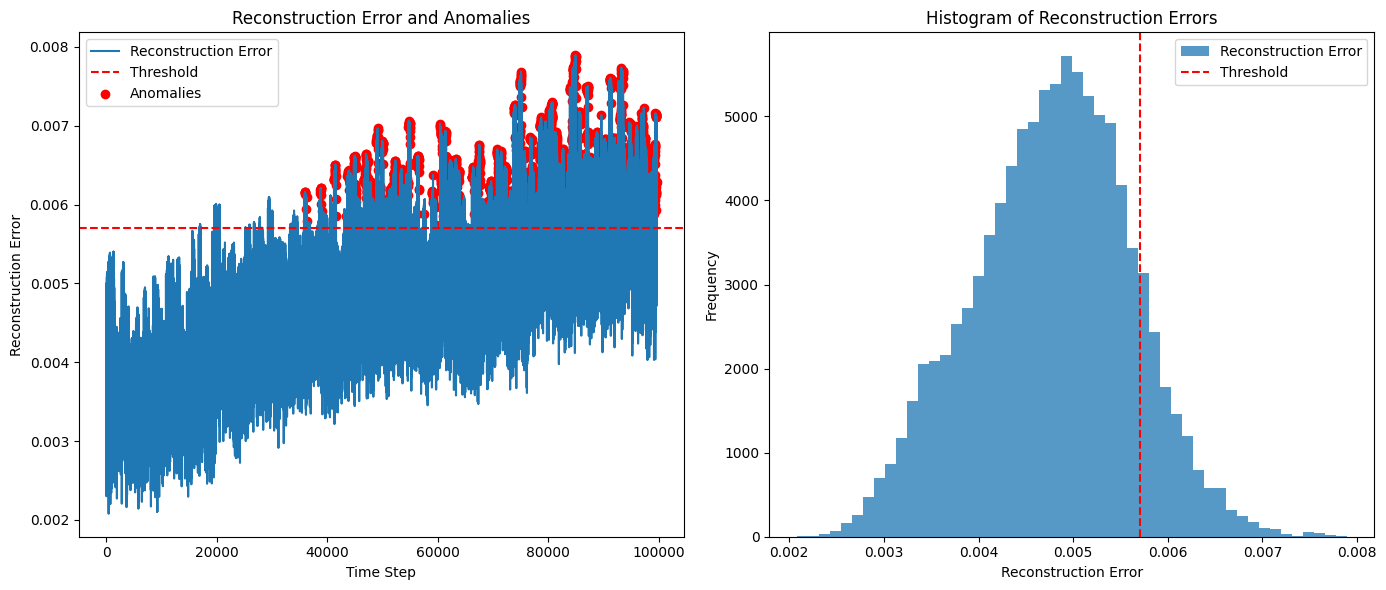

Total number of anomalies detected: 4980
Indices of anomalous points: [35937 35956 35975 ... 99574 99589 99593]
Reconstruction errors of anomalous points: [0.00614225 0.00615304 0.00615721 ... 0.00627723 0.00710582 0.00629087]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Compute reconstruction error for the test set
reconstructed_test = autoencoder.predict(X_test)
reconstruction_error_test = np.mean(np.abs(X_test - reconstructed_test), axis=2)

# Compute the threshold for anomalies
threshold = np.percentile(reconstruction_error_test, 95, axis=0, keepdims=True)

# Identify anomalies
anomalies = (reconstruction_error_test > threshold).astype(int)
total_anomalies = np.sum(anomalies)

# Plot reconstruction error and anomalies
plt.figure(figsize=(14, 6))

# Plot reconstruction error
plt.subplot(1, 2, 1)
plt.plot(reconstruction_error_test.flatten(), label='Reconstruction Error')
plt.axhline(y=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies.flatten() == 1), reconstruction_error_test.flatten()[anomalies.flatten() == 1], color='r', label='Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error and Anomalies')
plt.legend()

# Plot histogram of reconstruction errors
plt.subplot(1, 2, 2)
plt.hist(reconstruction_error_test.flatten(), bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(x=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.legend()

plt.tight_layout()
plt.show()

# Print total number of anomalies
print(f"Total number of anomalies detected: {total_anomalies}")

# Print details of points marked as anomalous
anomalous_points = np.where(anomalies.flatten() == 1)[0]
print("Indices of anomalous points:", anomalous_points)
print("Reconstruction errors of anomalous points:", reconstruction_error_test.flatten()[anomalous_points])